# Фильмы России 🎬

Заказчик этого исследования — Министерство культуры Российской Федерации.


Требовалось изучить рынок российского кинопроката и выявить текущие тренды. Особое внимание уделено фильмам, которые получили государственную поддержку.

Используются данные, опубликованные на портале открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск. 

**Содержание**<a id='toc0_'></a>    
1. [Подготовка       ](#toc1_)    
1.1. [Библиотеки     ](#toc1_1_)    
1.2. [Конфигурация     ](#toc1_2_)    
1.3. [Сервисные функции     ](#toc1_3_)    
2. [Данные      ](#toc2_)    
2.1. [Загрузка     ](#toc2_1_)    
2.2. [Подготовка к объединению     ](#toc2_2_)    
2.3. [Объединение данных     ](#toc2_3_)    
2.4. [Проверка объединения ](#toc2_4_)    
2.5. [Вывод по объединению данных ](#toc2_5_)    
3. [Изучение данных     ](#toc3_)    
3.1. [Изменение типов данных     ](#toc3_1_)    
3.2. [Обработка пропусков     ](#toc3_2_)    
3.3. [Обработка столбцов с категориальными значениями     ](#toc3_3_)    
3.4. [Обработка дубликатов     ](#toc3_4_)    
3.5. [Обработка столбцов с количественными значениями     ](#toc3_5_)    
3.5.1. [Столбец `refundable_support`   ](#toc3_5_1_)    
3.5.2. [Столбец `nonrefundable_support`   ](#toc3_5_2_)    
3.5.3. [Столбец `budget`   ](#toc3_5_3_)    
3.5.4. [Столбец `ratings`   ](#toc3_5_4_)    
3.5.5. [Столбец `box_office`   ](#toc3_5_5_)    
3.6. [Анализ некорректных записей  ](#toc3_6_)    
4. [Генерация новых столбцов     ](#toc4_)    
4.1. [Общий вывод по предобработке ](#toc4_1_)    
5. [Анализ гипотез     ](#toc5_)    
5.1. [Прокат фильмов по годам   ](#toc5_1_)    
5.2. [Сборы по годам   ](#toc5_2_)    
5.3. [Влияние возрастных ограничений на сборы в прокате     ](#toc5_3_)    
5.4. [Общий вывод по гипотезам ](#toc5_4_)    
6. [Анализ фильмов с ГосПоддержкой     ](#toc6_)    
6.1. [Изменение объема гос. поддержки по годам ](#toc6_1_)    
6.2. [Анализ окупаемости ](#toc6_2_)    
6.3. [Вывод по фильмам с гос. поддержкой](#toc6_3_)    
7. [Общий вывод  ](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка        [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки      [&#8593;](#toc0_)

In [1]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else:
    pass
    %pip install --upgrade numpy -q
    
%pip install --upgrade prettytable -q
%pip install --upgrade termcolor -q
%pip install --upgrade missingno -q
%pip install --upgrade matplotlib -q
%pip install --upgrade seaborn -q
%pip install --upgrade bottleneck -q
%pip install --upgrade pandas -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import os

from prettytable import PrettyTable
from pandas.api.types import is_numeric_dtype
from termcolor import colored
from IPython.display import display

### 1.2. <a id='toc1_2_'></a>Конфигурация      [&#8593;](#toc0_)

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:_.2f}'.format

### 1.3. <a id='toc1_3_'></a>Сервисные функции      [&#8593;](#toc0_)

In [4]:
def print_table_about_outliers(data: pd.DataFrame) -> None:
    table = PrettyTable()

    table.field_names = ['Столбец', 'Диапазон нормальных значений', 'Выходов за нижнюю границу', 'Выходов за верхнюю границу', 'Всего выбросов']

    for column in data.columns:
        if not is_numeric_dtype(data[column].dtype) or data[column].nunique() < 3:
            table.add_row([column, 'N/A', 'N/A', 'N/A', 'N/A'])
            continue
        
        q1, q3 = data[column].quantile([0.25, 0.75])
        iqr: float = q3 - q1
        lower_lim: float = q1 - 1.5 * iqr
        upper_lim: float = q3 + 1.5 * iqr
        
        num_of_values_under_lower_lim = len(data.query(f'{column} < @lower_lim'))
        num_of_values_below_upper_lim = len(data.query(f'{column} > @upper_lim'))
        
        table.add_row([
            column,
            f'[{lower_lim:_.2f}; {upper_lim:_.2f}]',
            colored(f'{num_of_values_under_lower_lim} ({num_of_values_under_lower_lim / len(data):.2%})', 'green' if num_of_values_under_lower_lim == 0 else 'red'),
            colored(f'{num_of_values_below_upper_lim} ({num_of_values_below_upper_lim / len(data):.2%})', 'green' if num_of_values_below_upper_lim == 0 else 'red'),
            colored(f'{num_of_values_under_lower_lim + num_of_values_below_upper_lim} ({(num_of_values_under_lower_lim + num_of_values_below_upper_lim) / len(data):.2%})', 'green' if (num_of_values_under_lower_lim + num_of_values_below_upper_lim )== 0 else 'red')
        ])
        
    print(table)

In [5]:
def print_table_about_nans(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.2%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [6]:
def draw_box_and_hist_plots(data: pd.DataFrame, col: str, bins: int=20) -> None:
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.boxplot(data, x=col, orient='h', ax=ax1)
    ax1.set_title(f'Ящик с усами для столбца `{col}`')
    ax1.set_xlabel(f'Значения столбца `{col}`')
    
    sns.histplot(data, x=col, bins=bins, ax=ax2)
    ax2.set_title(f'Гистограмма для столбца `{col}`')
    ax2.set_ylabel('Количество')
    ax2.set_xlabel(f'Значения столбца `{col}`')
    ax2.grid()

## 2. <a id='toc2_'></a>Данные       [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка      [&#8593;](#toc0_)

In [7]:
# dataset is not presented in the repository due to copyright
movies = pd.read_csv('./data/mkrf_movies.csv')   
movies.columns = [re.sub(r"(?<=\w)([A-Z])", r"_\1", c).lower() for c in movies.columns]

In [8]:
movies.shape

(7486, 15)

In [9]:
movies.sample(5)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
6386,"Девушка, которая застряла в паутине",121025218,2018-11-08T12:00:00.000Z,Художественный,"Метро Голдвин Майер, Нью Ридженси Пикчерз, Пас...",США - Великобритания - Германия - - Швеция - К...,Феде Альварес,"Ели Буш, Элизабет Кантийон, Берна Левин, Эми П...",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,5.9,"боевик,триллер,драма"
6950,Дылда,111008419,2019-06-14T12:00:00.000Z,Художественный,"ООО ""Нон-Стоп Продакшн""",Россия,К.Балагов,"С.Мелькумов, А.Роднянский",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"
2645,Миссия невыполнима: Племя изгоев,121015415,2015-07-20T12:00:00.000Z,Художественный,"Бэд Робот, Скайдэнс Продакшнз, ТиСи Продакшнз,...",США - Гонконг - КНР,Кристофер МакКуори,"Джей Джей Абрамс, Брайан Керк, Том Круз",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.1,"боевик,триллер,приключения"
4327,Ирония любви,111001110,2010-01-29T12:00:00.000Z,Художественный,"НП ""Генеральная дирекция международных кинофес...",Россия-Казахстан,"А.Черняев, Е.Рустембеков","Р.Давлетьяров, А.Котелевский, Е.Аманшаев",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.2,"мелодрама,комедия"
2808,Закат (2015),111018815,2015-11-02T12:00:00.000Z,Художественный,"ООО ""Студия ""Пассажир"", Studio Indie Productio...","Россия, Румыния",А.Анненский,"М.Ленских, М.Антонова, Н.Романюк, А.Савельев",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.2,"драма,детектив"


---

In [10]:
# dataset is not presented in the repository due to copyright
shows = pd.read_csv('./data/mkrf_shows.csv')
shows.columns = [re.sub(r"(?<=\w)([A-Z])", r"_\1", c).lower() for c in shows.columns]

In [11]:
shows.shape

(3158, 2)

In [12]:
shows.sample(5)

,pu_number,box_office
2739,124002110,350.00
1483,121011218,60_703_175.90
1437,121010318,345_686_872.16
2322,121027514,97_499_173.60
58,111001115,310_738.00


### 2.2. <a id='toc2_2_'></a>Подготовка к объединению      [&#8593;](#toc0_)

In [13]:
movies['pu_number'].dtype

dtype('O')

In [14]:
mask = movies['pu_number'].str.match(r'\D')
movies[mask]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
804,Паранормальный Якутск,111004112,2012-08-24T12:00:00.000Z,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
movies.loc[804]['pu_number']

' 111004112'

In [16]:
movies.loc[1797, 'pu_number'] = np.nan

In [17]:
movies['pu_number'] = movies['pu_number'].astype('float64')

In [18]:
movies['pu_number'].dtype

dtype('float64')

---

In [19]:
shows['pu_number'].dtype

dtype('int64')

---

In [20]:
mask = movies.duplicated(subset=['pu_number'], keep=False)
movies[mask]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
4638,Как жениться и остаться холостым,221_154_310.00,2010-12-17T12:00:00.000Z,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.0,"мелодрама,комедия"
4639,Иоанна - женщина на папском престоле /По роман...,221_154_310.00,2010-12-17T12:00:00.000Z,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история"
5067,Анализируй это!,221_054_410.00,2010-05-25T12:00:00.000Z,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал"
5068,Анализируй то!,221_054_410.00,2010-05-25T12:00:00.000Z,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал"


Мы видим, что разные фильмы (индексы `4638` и `4639`) имеют одинаковые номера прокатных удостоверений. Это определенно ошибка в данных. Такие строки лучше всего удалить.

Во втором случае (индексы `5067` и `5068`) это один и тот же фильм. Однако отличаются возрастные ограничения и рейтинги. Страна производства и режиссёр по сути одни и те же. Это скорее всего тоже является ошибкой. Правильнее всего удалить эти `2` строки.

In [21]:
movies.shape

(7486, 15)

In [22]:
movies = movies[~mask].reset_index(drop=True)

In [23]:
movies.shape

(7482, 15)

### 2.3. <a id='toc2_3_'></a>Объединение данных      [&#8593;](#toc0_)

In [24]:
df = pd.merge(movies, shows, on='pu_number', how='left')

In [25]:
df.sample(5)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
979,Мальчишник - Часть III,121_013_313.00,2013-05-21T12:00:00.000Z,Художественный,"Уорнер Бразерс, Грин Хэт Филмз",США,Тодд Филлипс,"Скотт Будник, Томас Талл",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.5,"комедия,криминал",NaN
5125,Крик 4,121_003_911.00,2011-03-23T12:00:00.000Z,Художественный,"Корвес Коракс Продакшн, Даймэншн Филмз, Миднай...",США,Уэсс Крэйвен,"Уэсс Крэйвен, Ия Лабунка",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.0,"ужасы,триллер,детектив",540.00
2212,Зеленый ад.,121_016_214.00,2014-07-29T12:00:00.000Z,Художественный,"Драгонфлай Интертейнмент, Собрас Интернэшнл Пи...",США - Чили,Илай Рот,"Мигель Асенсио, Молли Коннерс, Николас Лопез",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,5.3,"ужасы,приключения",2_569_090.00
5618,Атлантида,121_025_617.00,2017-11-30T12:00:00.000Z,Художественный,"Бабиека, Канзман, Инк Коннекшн, Понтас Филм, Л...",Испания - Франция,Ксавье Жанс,"Марк Альбела, Денис О.Делл",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.7,"ужасы,фантастика,фэнтези",20_954_669.00
3840,Зур концерт (Большой концерт).,217_027_010.00,2010-06-24T12:00:00.000Z,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.4. <a id='toc2_4_'></a>Проверка объединения  [&#8593;](#toc0_)

Проверим, что все объекты из исходного датасета (`movies`) вошли в итоговый датафрейм (`df`).

In [26]:
pd.Series.equals(movies['pu_number'], df['pu_number'])

True

### 2.5. <a id='toc2_5_'></a>Вывод по объединению данных  [&#8593;](#toc0_)

В результаты проверки были удалены 4 строки, у которых попарно совпадают номера прокатных удостоверений (`pu_number`). Далее соединили общую информацию о фильмах и информацию и их прокате в кинотеатрах. В конце сделана проверка, что все объекты из исходного датасета (`movies`) вошли в итоговый датафрейм (`df`).

## 3. <a id='toc3_'></a>Изучение данных      [&#8593;](#toc0_)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7482 entries, 0 to 7481
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7482 non-null   object 
 1   pu_number              7481 non-null   float64
 2   show_start_date        7482 non-null   object 
 3   type                   7482 non-null   object 
 4   film_studio            7464 non-null   object 
 5   production_country     7480 non-null   object 
 6   director               7473 non-null   object 
 7   producer               6914 non-null   object 
 8   age_restriction        7482 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6515 non-null   object 
 14  genres                 6506 non-null   object 
 15  box_

### 3.1. <a id='toc3_1_'></a>Изменение типов данных      [&#8593;](#toc0_)

In [28]:
df['show_start_date'] = pd.to_datetime(df['show_start_date'], format='%Y-%m-%dT%H:%M:%S.%fZ')

---

In [29]:
mask = (~df['ratings'].astype('str').str.match(r'\d+\.\d+')) & (df['ratings'].notna())
df[mask][:3]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
259,Прошлое,221_030_715.00,2015-07-29 12:00:00,Художественный,"20 Сенчюри Фокс де Архентина, Чемо, ЭйчБи Филм...",Аргентина - Бразилия,Эктор Бабенко,"Эктор Бабенко, Оскар Крамер, Хуго Сидмэн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,99%,"ужасы,триллер,драма",NaN
811,От винта!,114_000_212.00,2012-08-06 12:00:00,Анимационный,"ЗАО ""Продюсерский центр ""Парадиз""",Россия,О.Лопато,"Г.Нерсисян, А.Манасарян, А.Нерсесян",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,28%,"детский,приключения,комедия",1_740.00
1053,Песочный человек,121_029_212.00,2012-11-29 12:00:00,Художественный,Спотлайт Медиа Продакшн,Швейцария,Питер Луизи,"Дэвид Луизи, Питер Луизи",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,97%,"ужасы,фантастика,фэнтези",NaN


In [30]:
df.loc[mask, 'ratings'] = df.loc[mask, 'ratings'].str.replace('%', '').astype('float') / 10

In [31]:
df['ratings'] = df['ratings'].astype('float')

Еще раз проверим все типы данных.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7482 entries, 0 to 7481
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7482 non-null   object        
 1   pu_number              7481 non-null   float64       
 2   show_start_date        7482 non-null   datetime64[ns]
 3   type                   7482 non-null   object        
 4   film_studio            7464 non-null   object        
 5   production_country     7480 non-null   object        
 6   director               7473 non-null   object        
 7   producer               6914 non-null   object        
 8   age_restriction        7482 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

Типы данных были изменены всего в 2 столбцах:

- `show_start_date`: значения дат по умолчанию хранятся как строки. С помощью функции `pd.to_datetime` трансформировали в необходимый формат.
- `ratings`: для бОльшей части фильмов рейтинг представлен в виде десятичного числа (например, `7.8`). Однако для небольшого количества строк рейтинг был представлен в виде процентов (например, `56%`). Все значения были приведены к одному формату.

### 3.2. <a id='toc3_2_'></a>Обработка пропусков      [&#8593;](#toc0_)

In [33]:
df.shape

(7482, 16)

In [34]:
print_table_about_nans(df)

+-----------------------+----------------------+
|        Feature        | Missing values count |
+-----------------------+----------------------+
|         title         |      0 (0.00%)       |
|    show_start_date    |      0 (0.00%)       |
|          type         |      0 (0.00%)       |
|    age_restriction    |      0 (0.00%)       |
|       pu_number       |      1 (0.01%)       |
|   production_country  |      2 (0.03%)       |
|        director       |      9 (0.12%)       |
|      film_studio      |      18 (0.24%)      |
|        producer       |     568 (7.59%)      |
|        ratings        |     967 (12.92%)     |
|         genres        |     976 (13.04%)     |
|       box_office      |    4324 (57.79%)     |
|   refundable_support  |    7150 (95.56%)     |
| nonrefundable_support |    7150 (95.56%)     |
|         budget        |    7150 (95.56%)     |
|    financing_source   |    7150 (95.56%)     |
+-----------------------+----------------------+


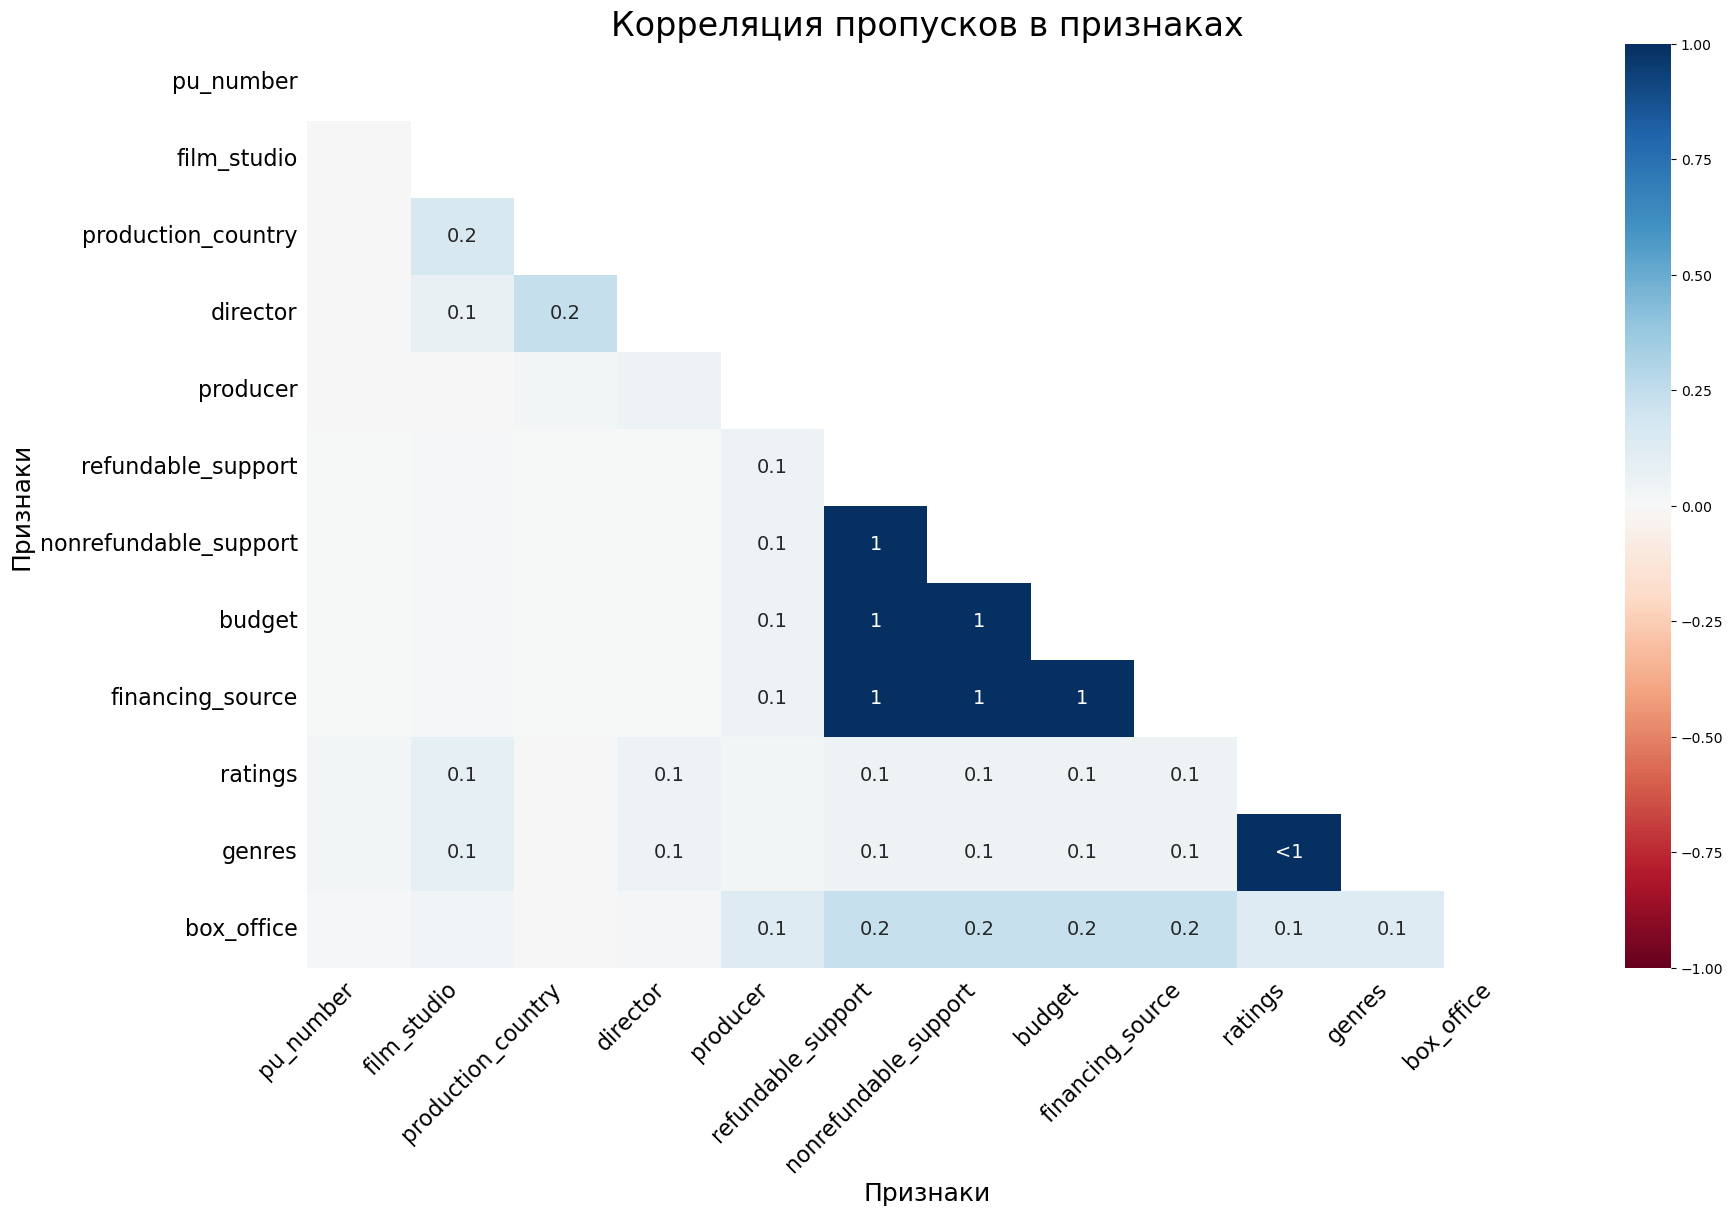

In [35]:
msno.heatmap(df);
plt.title('Корреляция пропусков в признаках', fontsize=24)
plt.xlabel('Признаки', fontsize=18)
plt.ylabel('Признаки', fontsize=18);

In [36]:
mask = df['production_country'].isna()
df[mask]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111_001_216.00,2016-02-09 12:00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.20,"детский,комедия",194_527.00
4441,Мульт личности. Выпуск 5,214_000_410.00,2010-01-25 12:00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN


In [37]:
mask = df['director'].isna()
df[mask][:3]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126_003_512.00,2012-12-04 12:00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,44_350.00
1735,Помпеи. Британский музей,126_003_413.00,2013-09-11 12:00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217_027_010.00,2010-06-24 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
mask = df['genres'].isna()
df[mask][:3]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
43,Мемуары гейши (по роману Артура Голдена),121_000_606.00,2012-12-14 12:00:00,Художественный,"Коламбия Пикчерз Корпорейшн, ДримУоркс ЭсКейДж...",США,Роб Маршалл,"Стивен Спилберг, Люси Фишер, Дуглас Уик, Джон ...",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,Жди меня,111_013_615.00,2015-08-25 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,"А.Столпер, Б.Иванов",NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,Дом из песка и тумана (по книге Андре Дюбуи III),221_037_813.00,2013-10-25 12:00:00,Художественный,Кобальт Пикчерз,США,Вадим Перельман,Майкл Лондон,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В данном датасете большая часть столбцов имеет пропуски, которые можно разделить на несколько категорий:

- Пропуск в столбец `pu_number` был добавлен нами намеренно, так как у этого фильма нет прокатного удостоверения.
- Столбцы `refundable_support`, `nonrefundable_support`, `budget`, `financing_source` имеют значения только для фильмов, которые получили гос. поддержку. Если данные отсутствуют - гос. поддержки не было. Данные пропуски являются намеренными. Оставим их как есть.
- Отсутствие данных в столбце `ratings` скорее всего значит, что фильм отсутствует на КиноПоиске, поэтому его рейтинг не известен. То есть данный пропуск также является намеренным. Оставим их.
- Столбец `box_office` был добавлен при объединении. Во втором датасете есть информация не о всех фильмах из первого датасета. Поэтому в этих строках стоят значения `NaN`. Данные значения в принципе можно заполнить, воспользовавшись интернетом, однако в рамках данного проекта просто оставим пропуски.
- Пропуски в остальных столбцах (`genres`, `producer`, `film_studio`, `production_country` и `director`) скорее всего являются случайными. Пропуски в этих столбцах также можно заполнить, взяв информацию из интернета.

### 3.3. <a id='toc3_3_'></a>Обработка столбцов с категориальными значениями      [&#8593;](#toc0_)

In [39]:
df['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', ' Художественный', ' Анимационный',
       'Музыкально-развлекательный'], dtype=object)

In [40]:
df['type'] = df['type'].str.strip()

In [41]:
df['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', 'Музыкально-развлекательный'], dtype=object)

---

In [42]:
df['age_restriction'].unique()

array(['«18+» - запрещено для детей', '«6+» - для детей старше 6 лет',
       '«12+» - для детей старше 12 лет',
       '«16+» - для детей старше 16 лет',
       '«0+» - для любой зрительской аудитории'], dtype=object)

Для удобства уберем комментарии.

In [43]:
df['age_restriction'] = df['age_restriction'].apply(lambda s: re.sub(r'.*«(.*?)».*', r'\1', s))

---

In [44]:
df['production_country'].unique()[:10]

array(['США', 'СССР', 'Франция', 'СССР, Венгрия',
       'Германия-Великобритания', 'Великобритания - Италия',
       'Чехословакия', 'США - Франция - Турция', 'Новая Зеландия',
       'Канада - Франция - Испания'], dtype=object)

---

In [45]:
df['genres'].unique()[:10]

array(['боевик,драма,мелодрама', 'драма,военный',
       'фантастика,боевик,триллер', 'драма', 'мелодрама,комедия',
       'мюзикл,мелодрама,комедия', 'комедия,криминал',
       'боевик,триллер,детектив', 'боевик,драма,приключения',
       'драма,спорт'], dtype=object)

---

In [46]:
df['director'].unique()[:10]

array(['Кевин Костнер', 'Е.Матвеев', 'Тимур Бекмамбетов', 'В.Абдрашитов',
       'В.Меньшов', 'Джон Туртурро', 'Эрик Беснард', 'В.Титов',
       'Пол Грингросс', 'М.Туманишвили'], dtype=object)

---

Бо&#769;льшая часть столбцов содержат перечисления: несколько стран, несколько жанров, несколько фамилий и так далее. При этом формат перечислений не определен. Среди основных проблем можно выделить разные разделители (запятые, дефисы), а также где-то пробелы есть, где-то пробелов нет.

Также были обнаружены проблемы в столбце `type`. Некоторые значения содержали пробелы. Все пробелы были удалены. Таким образом мы избавились от неявных дубликатов.

### 3.4. <a id='toc3_4_'></a>Обработка дубликатов      [&#8593;](#toc0_)

In [47]:
original = df.copy()

In [48]:
df.duplicated().sum()

0

В данном датасете отсутствуют полные дубликаты. Возможно, есть неявные дубликаты. Например, один тот же фильм мог появиться под разными названиями.

Среди причин появления полных дубликатов в первую очередь стоит отнести техническую ошибку. Также нельзя исключать человеческий фактор.

Теперь проверим неявные дубликаты в столбцах `title` и `pu_number`.

In [49]:
df.duplicated(subset=['title', 'pu_number']).sum()

0

In [50]:
df.duplicated(subset='pu_number').sum()

0

In [51]:
mask = df.duplicated(subset='title', keep=False)

In [52]:
df[mask].head()

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2,Особо опасен,221_038_416.00,2016-10-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18+,NaN,NaN,NaN,NaN,6.80,"фантастика,боевик,триллер",NaN
3,Особо опасен,221_026_916.00,2016-06-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18+,NaN,NaN,NaN,NaN,6.80,"фантастика,боевик,триллер",NaN
4,Особо опасен,221_030_815.00,2015-07-29 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18+,NaN,NaN,NaN,NaN,6.80,"фантастика,боевик,триллер",NaN
12,Малышка на миллион /По мотивам рассказов Ф.Х.Т...,221_011_415.00,2015-04-03 12:00:00,Художественный,"Уорнер Бразерс, Лейкшор Интертейнмент, Малпасо...",США,Клинт Иствуд,"Клинт Иствуд, Том Розенберг, Альберт С.Рудди, ...",16+,NaN,NaN,NaN,NaN,8.10,"драма,спорт",NaN
26,Оружейный барон,221_012_515.00,2015-04-03 12:00:00,Художественный,"Вэ И Пэ Медиенфондс 3, Асендант Пикчерз, Сатур...",США - Франция - Турция,Эндрю Никкол,"Норман Голуайтли, Энди Грош, Николас Кейдж, Эн...",18+,NaN,NaN,NaN,NaN,7.70,"боевик,драма,криминал",NaN


Мы видим большое количество строк в которых фильмы совпадают, однако это не является проблемой. Фильм мог выходить в прокат в разное время и поэтому имеет несколько разных номеров прокатных удостоверений.

### 3.5. <a id='toc3_5_'></a>Обработка столбцов с количественными значениями      [&#8593;](#toc0_)

In [53]:
cols = ['refundable_support', 'nonrefundable_support', 'budget', 'ratings', 'box_office']

In [54]:
df[cols].describe()

,refundable_support,nonrefundable_support,budget,ratings,box_office
count,332.00,332.00,332.00,6_515.00,3_158.00
mean,11_864_457.83,48_980_988.89,127_229_716.68,6.49,76_478_696.16
std,24_916_555.26,59_980_117.92,188_588_333.12,1.11,240_353_122.82
min,0.00,0.00,0.00,1.00,0.00
25%,0.00,25_000_000.00,42_000_000.00,5.90,86_239.00
50%,0.00,30_000_000.00,68_649_916.00,6.60,2_327_987.55
75%,15_000_000.00,40_375_000.00,141_985_319.50,7.20,23_979_671.02
max,180_000_000.00,400_000_000.00,2_305_074_303.00,9.90,3_073_568_690.79


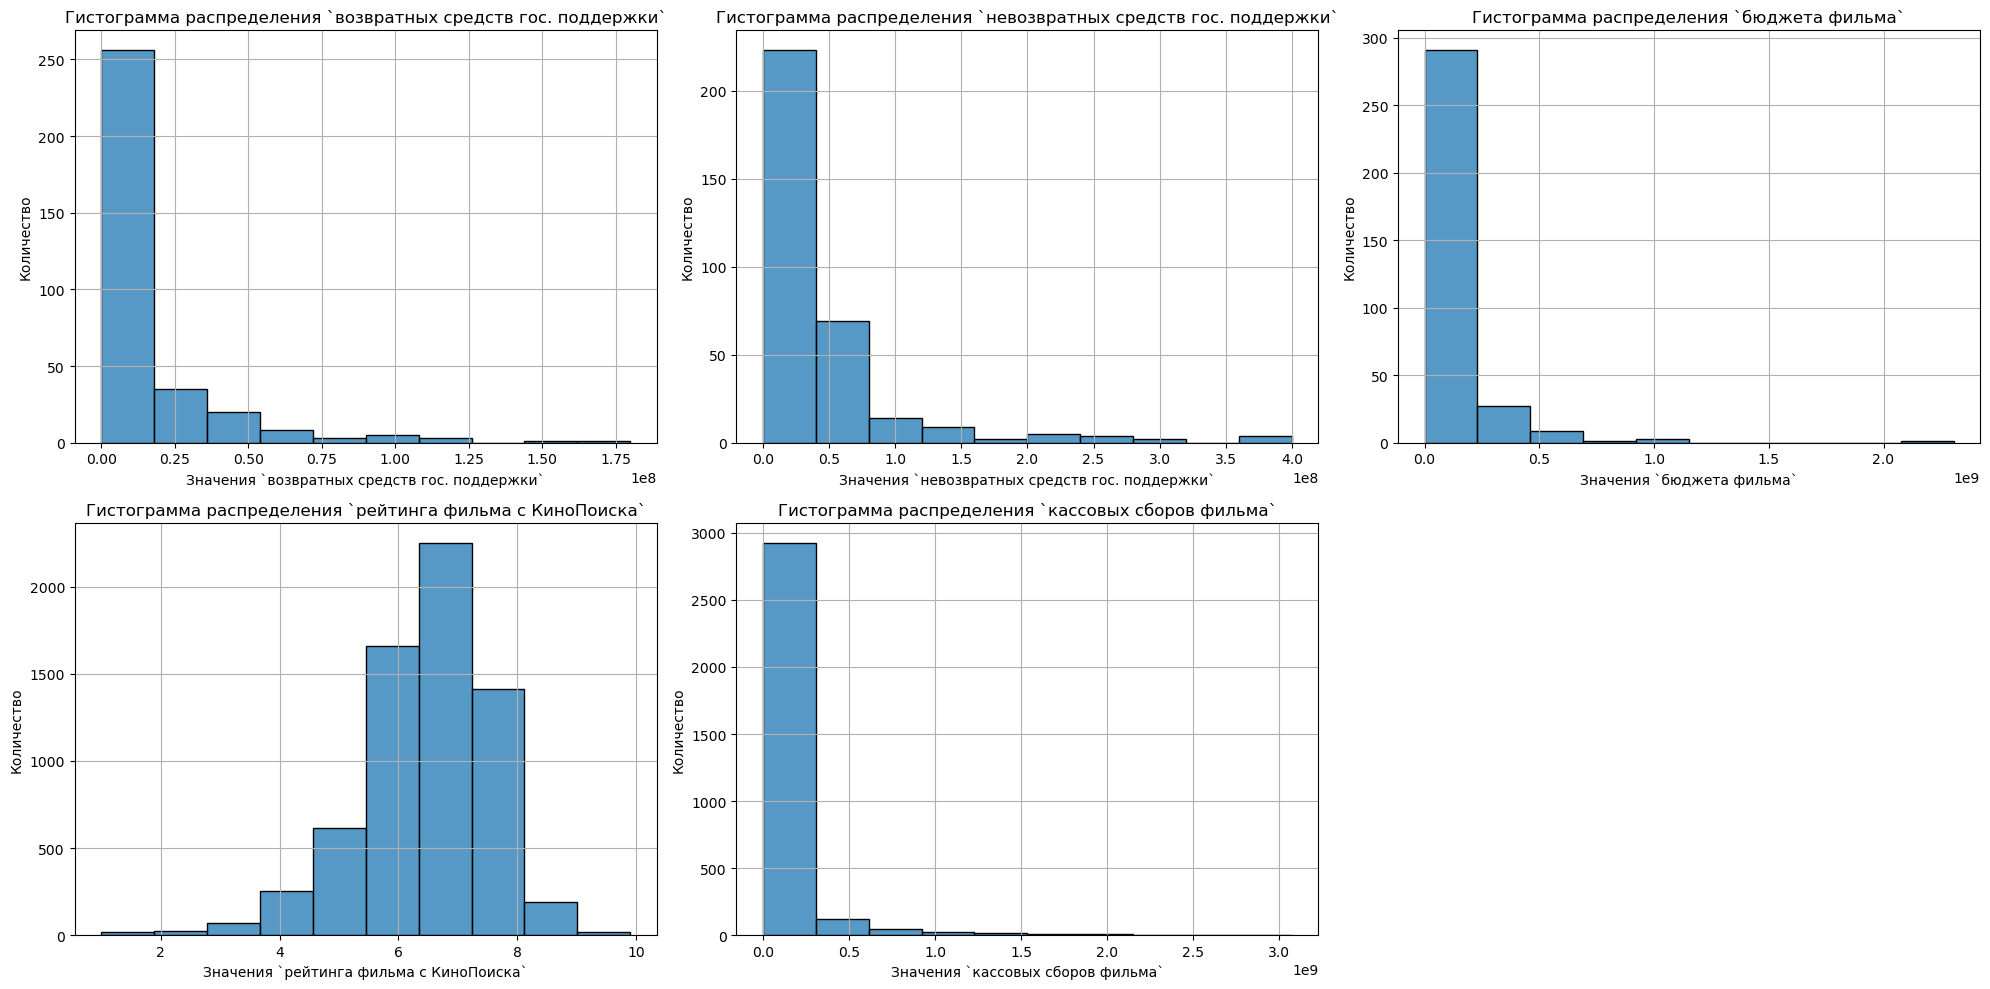

In [55]:
cols_num = 3
rows_num = int(np.ceil(len(cols) / 3))

titles = [
    'возвратных средств гос. поддержки',
    'невозвратных средств гос. поддержки',
    'бюджета фильма',
    'рейтинга фильма с КиноПоиска',
    'кассовых сборов фильма',
]

fig, axes = plt.subplots(rows_num, cols_num)
fig.set_figwidth(20)
fig.set_figheight(10)
for i, col in enumerate(cols):
    axe = axes[i // 3][i % 3]
    sns.histplot(data=df, x=col, bins=10, ax=axe)
    axe.set_title(f'Гистограмма распределения `{titles[i]}`')
    axe.set_xlabel(f'Значения `{titles[i]}`')
    axe.set_ylabel(f'Количество')
    axe.grid()

axes[1, 2].set_visible(False)
plt.tight_layout()

#### 3.5.1. <a id='toc3_5_1_'></a>Столбец `refundable_support`    [&#8593;](#toc0_)

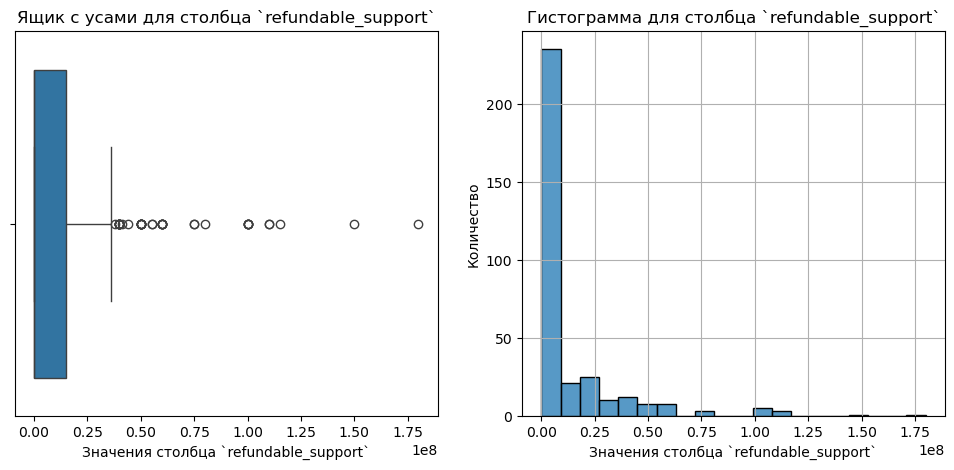

In [56]:
draw_box_and_hist_plots(df, 'refundable_support')

#### 3.5.2. <a id='toc3_5_2_'></a>Столбец `nonrefundable_support`    [&#8593;](#toc0_)

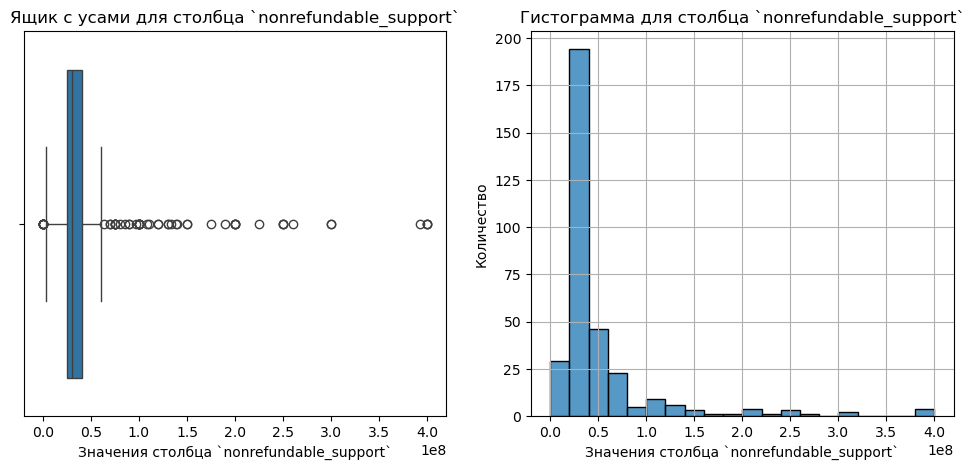

In [57]:
draw_box_and_hist_plots(df, 'nonrefundable_support')

In [58]:
mask = df['nonrefundable_support'] > 3.5 * 1e8
df[mask]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2920,Экипаж .,111_005_416.00,2016-03-21 12:00:00,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,Н.Лебедев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",6+,50_000_000.00,392_104_482.00,635_283_867.00,Фонд кино,7.60,"драма,триллер,приключения",1_402_255_390.00
5649,Движение вверх,111_011_817.00,2017-12-21 12:00:00,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,А.Мегердичев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",6+,0.00,400_000_000.00,590_192_191.00,Фонд кино,7.50,"спорт,драма",2_779_686_144.00
7460,Союз спасения,111_022_019.00,2019-12-26 12:00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",12+,100_000_000.00,400_000_000.00,980_000_000.00,Фонд кино,6.00,"история,биография,драма",717_703_185.53
7470,Вторжение,111_022_519.00,2019-12-23 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",12+,100_000_000.00,400_000_000.00,944_000_000.00,Фонд кино,5.70,"фантастика,боевик",NaN


#### 3.5.3. <a id='toc3_5_3_'></a>Столбец `budget`    [&#8593;](#toc0_)

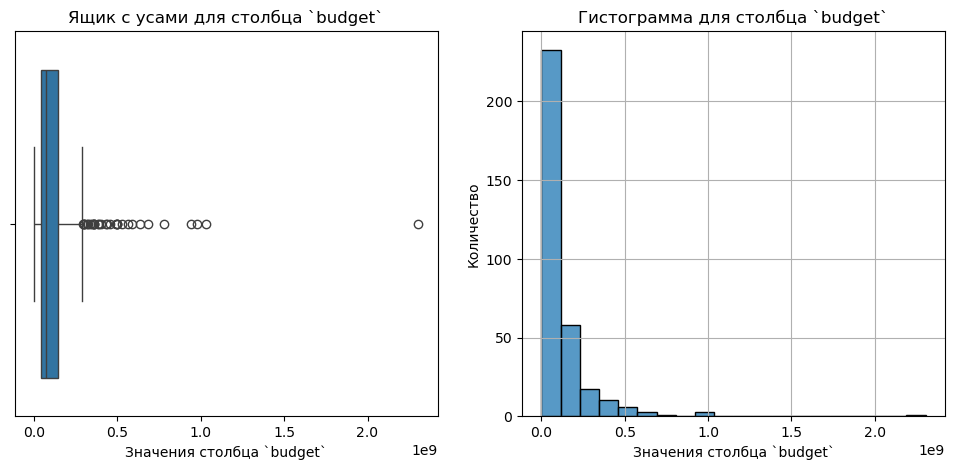

In [59]:
draw_box_and_hist_plots(df, 'budget')

In [60]:
mask = df['budget'] > 2e9
mask.sum()

1

In [61]:
df[mask].iloc[0]

title                                                 Тайна Печати Дракона
pu_number                                                   111_012_819.00
show_start_date                                        2019-09-12 12:00:00
type                                                        Художественный
film_studio              ООО "Кинокомпания "СТВ"; ООО "РФГ Корп"; ООО "...
production_country                                            Россия-Китай
director                                                       О.Степченко
producer                                            С.Сельянов, А.Петрухин
age_restriction                                                         6+
refundable_support                                          180_000_000.00
nonrefundable_support                                        90_000_000.00
budget                                                    2_305_074_303.00
financing_source                                                 Фонд кино
ratings                  

#### 3.5.4. <a id='toc3_5_4_'></a>Столбец `ratings`    [&#8593;](#toc0_)

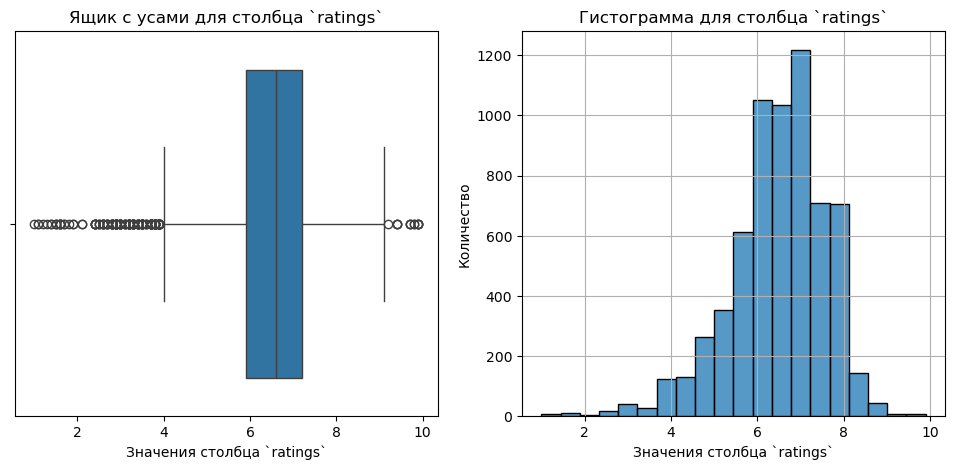

In [62]:
draw_box_and_hist_plots(df, 'ratings')

#### 3.5.5. <a id='toc3_5_5_'></a>Столбец `box_office`    [&#8593;](#toc0_)

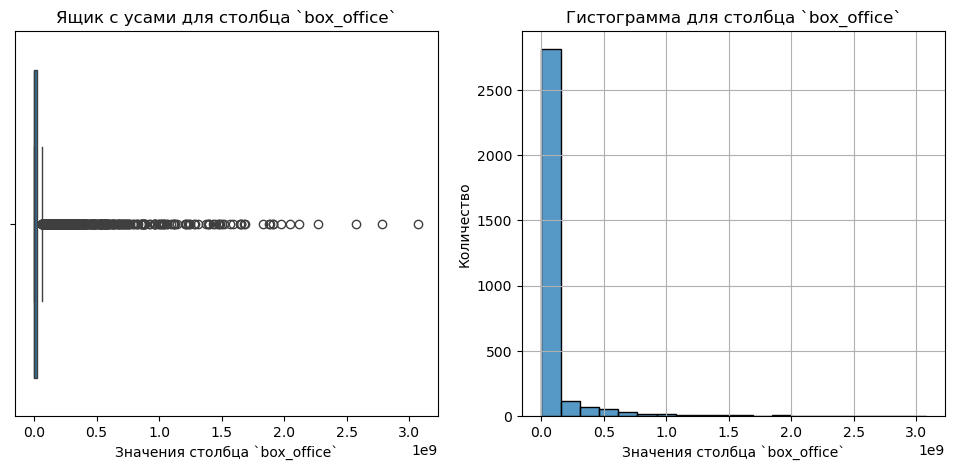

In [63]:
draw_box_and_hist_plots(df, 'box_office')

### 3.6. <a id='toc3_6_'></a>Анализ некорректных записей   [&#8593;](#toc0_)

In [64]:
mask = (df['budget'] < (df['refundable_support'] + df['nonrefundable_support'])) | (df['budget'] == 0)
mask.sum()

17

In [65]:
df.loc[mask, 'budget'].value_counts()

budget
0.00    17
Name: count, dtype: int64

In [66]:
df[mask].head(2)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2053,14+,111_023_614.00,2014-12-19 12:00:00,Художественный,"ООО Киностудия ""Сентябрь""",Россия,А.Зайцев,"О.Гранина, А.Зайцев",16+,0.00,23_000_000.00,0.00,"Министерство культуры, Фонд кино",6.60,мелодрама,10_234_016.10
2058,Дуxless 2,111_000_415.00,2015-01-26 12:00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",16+,0.00,75_000_000.00,0.00,Фонд кино,6.60,драма,446_163_511.00


Обнаружено 17 фильмов с нулевым бюджетом. Это определенно является ошибкой. Заменим эти значения на `NaN`.

In [67]:
df.loc[mask, 'budget'] = np.nan

---

**Общий вывод по столбцам с количественными значениями:**

Обнаружено большое количество значений, которые можно отнести к выбросам (то есть они выходят за границы "усов"). Однако назвать эти значения аномальными в данном случае нельзя.

Исключение составляет фильм "Тайна Печати Дракона" с бюджетом в `2.3` миллиарда. Это значения было удалено из датасета. Остальные значения оставлены в датасете, так как рейтинг `1/10` на КиноПоиске хоть и редкость, но все же возможная ситуация.

Также было обнаружено `17` фильмов, для которых значение бюджета составляет `0`. Это определенно является ошибкой. Данные "нули" были заменены на `NaN`

## 4. <a id='toc4_'></a>Генерация новых столбцов      [&#8593;](#toc0_)

In [68]:
df['show_start_year'] = df['show_start_date'].dt.year

In [69]:
df['main_director'] = df['director'].str.split(',').str[0]

In [70]:
df['main_genre'] = df['genres'].str.split(',').str[0]

In [71]:
df['support_part'] = ((df['refundable_support'] + df['nonrefundable_support']) / df['budget']).round(4)

Проверим, что новые столбцы добавлены корректно.

In [72]:
df.sample(5)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,show_start_year,main_director,main_genre,support_part
4330,"Отправь их в ад, Мэлоун",221_007_310.00,2010-01-20 12:00:00,Художественный,"Мэлоун Продакшнз, Норт Бай Нортвест Продакшнз",США,Рассел Малкэй,"Эрик Андерсон, Мартин Дж.Бараб, Рич Кауэн",18+,NaN,NaN,NaN,NaN,6.50,"боевик,триллер,криминал",NaN,2010,Рассел Малкэй,боевик,NaN
2790,В одну сторону (2006),121_009_316.00,2016-04-21 12:00:00,Художественный,"Байрефут Филмз, Ифтел Филм, Индиго Пикчерз, Ма...",Германия,Рето Салимбени,"Клаус Доле. Шеннон Милдон, Тиль Швайгер",18+,NaN,NaN,NaN,NaN,7.10,триллер,NaN,2016,Рето Салимбени,триллер,NaN
4706,"Дикие травы /По роману Кристиана Гайи ""Инцидент""/",121_012_810.00,2010-07-08 12:00:00,Художественный,"Франс 2 Синема, Студио Канал, Эф Комм Фильм, Б...",Франция - Италия,Ален Рене,"Жан-Луи Ливии, Джули Сальвадор",12+,NaN,NaN,NaN,NaN,5.90,"драма,мелодрама,комедия",NaN,2010,Ален Рене,драма,NaN
2301,Нежданно-негаданно_,111_018_014.00,2014-12-01 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Г.Мелконян,NaN,12+,NaN,NaN,NaN,NaN,7.00,"мелодрама,комедия",NaN,2014,Г.Мелконян,мелодрама,NaN
1516,47 ронинов,121_027_213.00,2013-10-21 12:00:00,Художественный,"Мувинг Пикчерз Компани, Мид Атлантик Филмз, Аш...",США,Карл Ринш,"Эрик МакЛеод, Скотт Стубер, Памела Эбди",12+,NaN,NaN,NaN,NaN,6.70,"фэнтези,боевик,драма",NaN,2013,Карл Ринш,фэнтези,NaN


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7482 entries, 0 to 7481
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7482 non-null   object        
 1   pu_number              7481 non-null   float64       
 2   show_start_date        7482 non-null   datetime64[ns]
 3   type                   7482 non-null   object        
 4   film_studio            7464 non-null   object        
 5   production_country     7480 non-null   object        
 6   director               7473 non-null   object        
 7   producer               6914 non-null   object        
 8   age_restriction        7482 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 315 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

### 4.1. <a id='toc4_1_'></a>Общий вывод по предобработке  [&#8593;](#toc0_)

В данном разделе по предобработке данных были проделаны следующие операции:
- изменены типы данных для столбцов, которые это требуют
- обработка неявных дубликатов в столбце `type`
- обработка дубликатов в столбцах с категориальными данными: `pu_number` и `title`
- проверка выбросов и аномальных значений в столбцах в количественными данными

## 5. <a id='toc5_'></a>Анализ гипотез      [&#8593;](#toc0_)

### 5.1. <a id='toc5_1_'></a>Прокат фильмов по годам    [&#8593;](#toc0_)

Отфильтруем фильмы, по которым есть информация о сборах.

In [74]:
mask = df['box_office'].notna()
df_with_box_office =df[mask]

In [75]:
years = sorted(df['show_start_year'].unique())

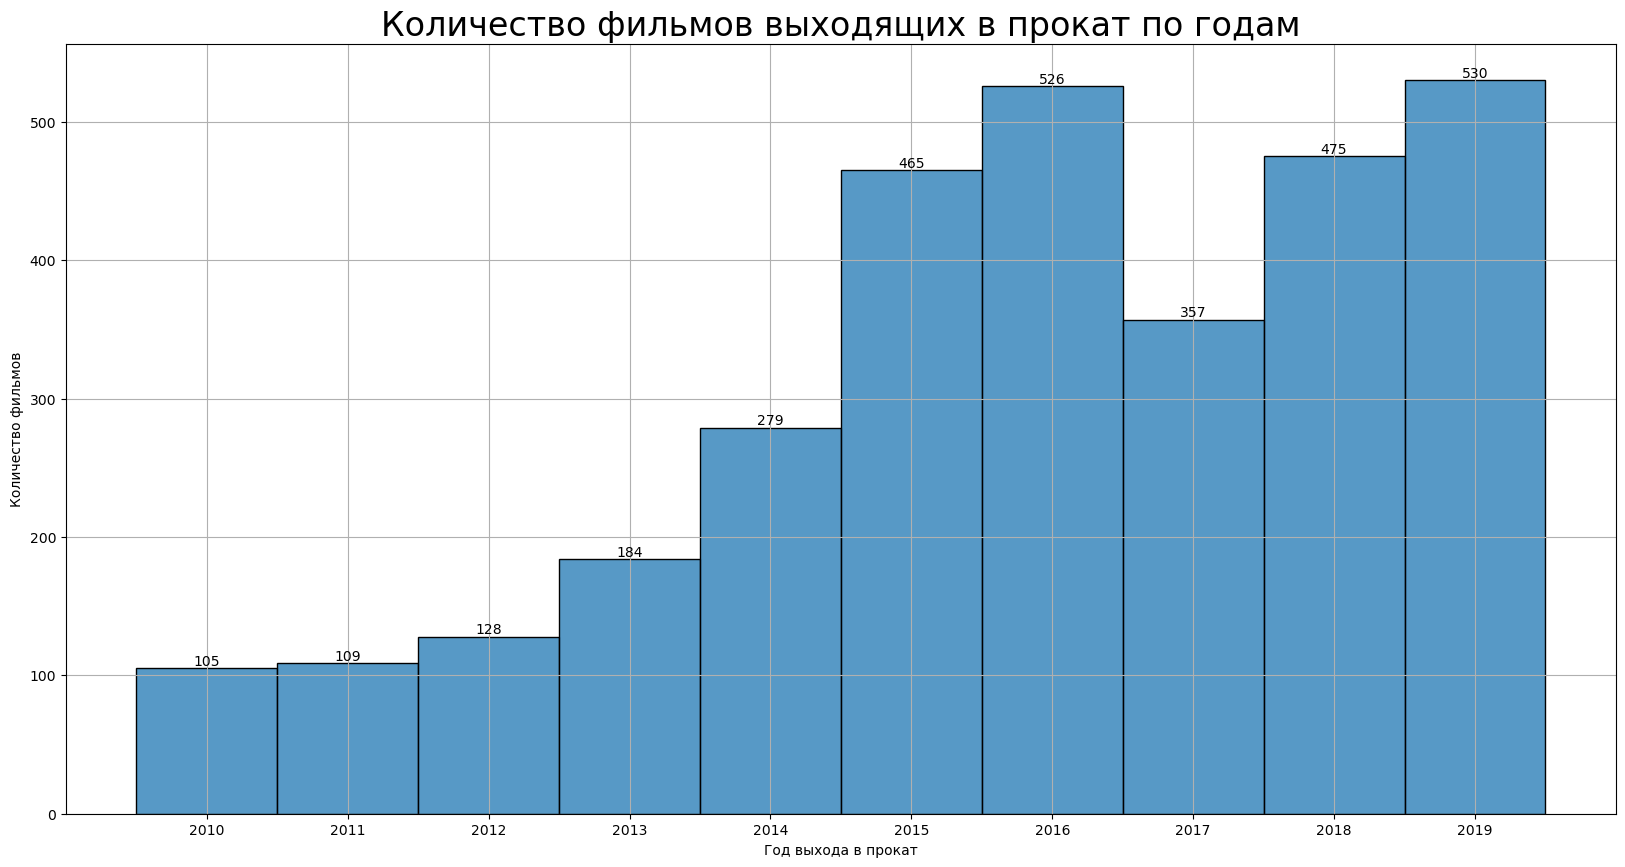

In [76]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(df_with_box_office['show_start_year'], bins=10, discrete=True);
plt.grid()
ax.set_xticks(ticks=years);
ax.bar_label(ax.containers[0]);
ax.set_title('Количество фильмов выходящих в прокат по годам', fontsize=24)
ax.set_ylabel('Количество фильмов')
ax.set_xlabel('Год выхода в прокат')
plt.show()


In [77]:
temp = df_with_box_office.groupby('show_start_year')['show_start_year'].count() / df.groupby('show_start_year')['show_start_year'].count() * 100
temp

show_start_year
2010   10.70
2011   17.52
2012   21.59
2013   29.21
2014   34.57
2015   65.96
2016   64.30
2017   70.69
2018   53.31
2019   56.99
Name: show_start_year, dtype: float64

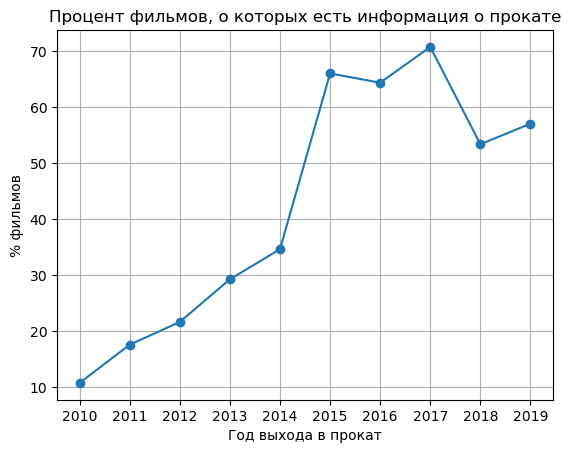

In [78]:
temp.plot(style='o-', xticks=temp.index, grid=True);
plt.title('Процент фильмов, о которых есть информация о прокате')
plt.xlabel('Год выхода в прокат')
plt.ylabel('% фильмов')
plt.show()

Период `2010` - `2014`  представлен небольшим количеством информации. Процент фильмов, о которых есть информация о прокате, совсем небольшой. В 2010 это всего `11%`. К `2014` он подрос до `35%`. Но это всего лишь около трети.

Далее (`2015` - `2019`) информации уже больше. В среднем она составляет около `62%`.

Можно выделить следующие факты:
- С `2010` по `2016` информация о прокате росла. Особенно резкий рост был с `2014` по `2015` год (почти `35%`)
- С `2016` по `2018` наблюдается снижение.
- С `2018` по `2019` вновь наблюдается рост.

Менее всего данных представлен `2010` год. Информация есть всего лишь о `11%`.  
А вот полнее всего представлен `2017` год. Для этого года информация о прокате есть более чем для `70%` фильмов.

### 5.2. <a id='toc5_2_'></a>Сборы по годам    [&#8593;](#toc0_)

In [79]:
pivot = df_with_box_office.pivot_table(index='show_start_year', values='box_office', aggfunc=['mean', 'median'])
pivot.columns = ['mean_box_office', 'median_box_office']
pivot

,mean_box_office,median_box_office
show_start_year,,
2010,23_130.04,1_700.00
2011,129_383.17,3_000.00
2012,54_339.24,5_660.00
2013,161_954.92,3_522.50
2014,26_684_415.27,18_160.00
2015,84_940_570.31,4_920_933.00
2016,91_000_569.85,3_846_679.41
2017,136_032_793.33,9_968_340.00
2018,104_565_059.23,8_891_102.21


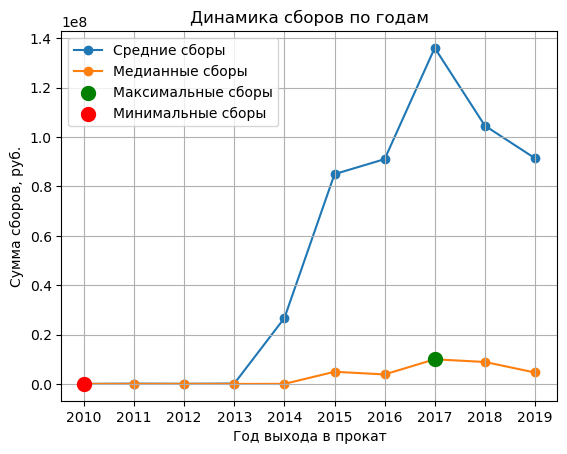

In [80]:
pivot.plot(grid=True, style='o-', zorder=1)
plt.scatter(pivot['median_box_office'].idxmax(), pivot['median_box_office'].max(), color='green', zorder=2, lw=5)
plt.scatter(pivot['median_box_office'].idxmin(), pivot['median_box_office'].min(), color='red', zorder=2, lw=5)
plt.title('Динамика сборов по годам')
plt.xlabel('Год выхода в прокат')
plt.ylabel('Сумма сборов, руб.')
plt.xticks(pivot.index)
plt.legend(['Средние сборы', 'Медианные сборы', 'Максимальные сборы', 'Минимальные сборы'])
plt.show()

In [81]:
df_with_box_office.query('show_start_year == 2010')[:2]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,show_start_year,main_director,main_genre,support_part
3790,"Легион_.(Фильм содержит сцены ужасов, насилия ...",121_000_310.00,2010-01-25 12:00:00,Художественный,Болд Филмз,США,Скотт Стюарт,"Дэвид Ланкастер, Майкл Литвак",18+,NaN,NaN,NaN,NaN,NaN,NaN,560.00,2010,Скотт Стюарт,NaN,NaN
3791,Белка и Стрелка. Звездные собаки,114_000_310.00,2010-01-29 12:00:00,Анимационный,"ОАО ""ЦНФ""",Россия,"С.Ушаков, И.Евланникова",С.А.Зернов,0+,NaN,NaN,NaN,NaN,6.00,"мультфильм,комедия,приключения",22_247.00,2010,С.Ушаков,мультфильм,NaN


Суммы сборов в период `2010` - `2014` крайне маленькие. И информация явно ошибочная. Например, мультфильм "Белка и Стрелка: Звездные собаки". В данном датасете сборы составляют около `22` тысяч рублей. Однако на КиноПоиске указана информация, что сборы в РФ составили `$6 293 840` и `$7 380 724` по миру.

Подобные строки требуют дальнейшего анализа.

Также мы видим, что среднее и медианное значения очень сильно отличаются. Это говорит о том, что
1) Есть небольшая часть фильмов с огромными сборами.

и\или

2) Для части фильмов сборы указаны некорректно. И мы выяснили, что такие строки действительно есть, особенно в период `2010` - `2014`.


**Динамика:**
- Период с `2010` по `2014` слишком мало представлен, чтобы делать выводы.
- Период с `2014` по `2017` представлен стремительным ростом.
- В период с `2017` по `2019` наблюдается падение сборов.

При этом самые маленькие медианные сборы в `2010` года, а самые большие - в `2017`.

### 5.3. <a id='toc5_3_'></a>Влияние возрастных ограничений на сборы в прокате      [&#8593;](#toc0_)

In [82]:
m = (df_with_box_office['show_start_year'] >= 2015) & (df_with_box_office['show_start_year'] <= 2019)
table = df_with_box_office[m].pivot_table(index='age_restriction', values='box_office',aggfunc=['mean', 'median'])
table.columns = ['mean', 'median']
table = table.iloc[[0, 4, 1, 2, 3]]
table

,mean,median
age_restriction,,
0+,8_890_960.72,2_943_318.70
6+,176_020_854.26,13_736_207.98
12+,174_193_812.15,5_065_044.25
16+,94_453_085.27,5_600_007.00
18+,51_464_161.08,6_154_439.17


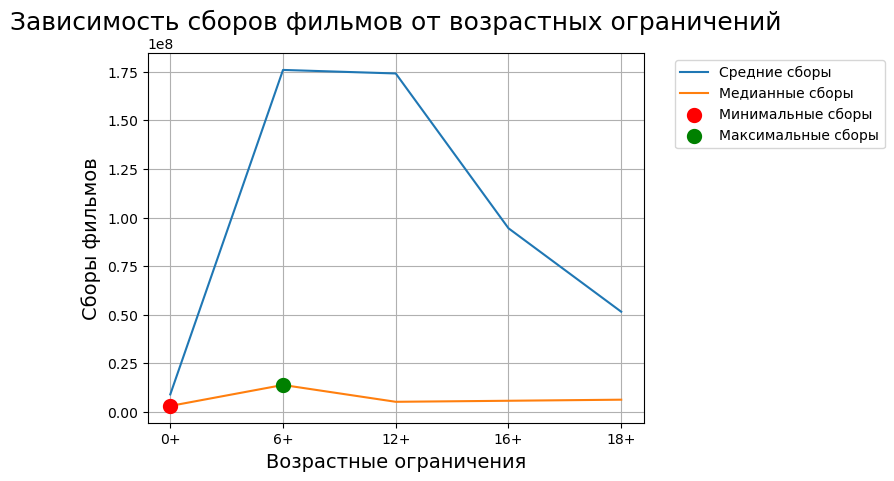

In [83]:
table.plot()
plt.grid()
plt.xticks(ticks=range(len(table.index)), labels=['0+', '6+', '12+', '16+', '18+'])
plt.scatter(table['median'].argmin(), table['median'].min(), lw=5, color='red', zorder=2)
plt.scatter(table['median'].argmax(), table['median'].max(), lw=5, color='green', zorder=2)
plt.title('Зависимость сборов фильмов от возрастных ограничений', fontsize=18)
plt.xlabel('Возрастные ограничения', fontsize=14)
plt.ylabel('Сборы фильмов', fontsize=14)
plt.legend(['Средние сборы', 'Медианные сборы', 'Минимальные сборы', 'Максимальные сборы'], bbox_to_anchor=(1.5, 1))
plt.show()

Возрастные ограничения имеют смешанное влияние на сборы фильмов в прокате. Самое кассовые фильмы (по средним сборам) представлены в категориях `6+` и `12+`. Однако их небольшое количество. Медианные значения сборов имеют не такой большой разброс. И тут самые кассовые фильмы опять же представлены в категории `6+`.

Наименьшие кассовые сборы представлены в категории `0+` и для средних и для медианных показателей.

---

In [84]:
table = df_with_box_office.pivot_table(index='show_start_year', columns='age_restriction', values='box_office',aggfunc=['mean', 'median'])
table

mean                                              \
age_restriction            0+            12+            16+           18+   
show_start_year                                                             
2010                85_800.50       7_067.41       6_319.17      6_798.12   
2011               449_995.70       9_995.05       7_065.06        520.00   
2012                75_549.43       6_795.88      66_412.57     10_740.00   
2013                73_251.42     348_505.61      14_623.77    322_577.85   
2014             9_883_217.32  30_771_218.14   6_637_562.03 49_104_727.71   
2015             9_719_348.16 186_521_671.35  67_667_386.13 41_153_851.27   
2016             3_664_118.26 148_834_713.71  91_563_453.53 44_992_912.71   
2017            76_532_976.67 191_498_235.63 154_917_709.92 65_656_432.52   
2018             6_489_800.42 212_944_651.65 105_792_322.74 48_939_025.15   
2019             5_915_355.61 149_178_809.10  71_648_421.26 55_310_362.31   

                                      median                             \
age_restriction             6+            0+           12+          16+   
show_start_year                                                           
2010                       NaN      6_052.50      2_650.00     1_000.00   
2011                    450.00      7_010.00      3_741.50     2_835.00   
2012                 71_463.12     18_067.50      3_685.00     1_600.00   
2013                 13_836.62     13_225.00      2_250.00     3_300.00   
2014             57_687_148.11    190_855.00      6_037.50    13_640.00   
2015            164_184_893.80  2_943_318.70 15_351_562.50 4_676_819.40   
2016            172_187_800.12  2_571_294.10  4_690_635.25 5_133_021.74   
2017            268_580_936.57 22_178_956.00  9_010_548.00 9_702_077.00   
2018            148_602_567.99  3_616_937.28  8_931_965.66 9_010_638.62   
2019            158_673_440.13  3_885_434.50  3_405_545.76 3_210_717.81   

                                            
age_restriction          18+            6+  
show_start_year                             
2010                  915.00           NaN  
2011                  520.00        450.00  
2012                1_385.00      6_475.00  
2013                1_775.00      3_457.50  
2014              180_108.00    125_810.00  
2015            4_616_614.70 20_380_982.20  
2016            6_107_001.74  3_026_256.15  
2017            8_212_677.00 51_992_103.00  
2018            7_179_466.00 14_688_850.32  
2019            5_603_216.55 12_875_350.34

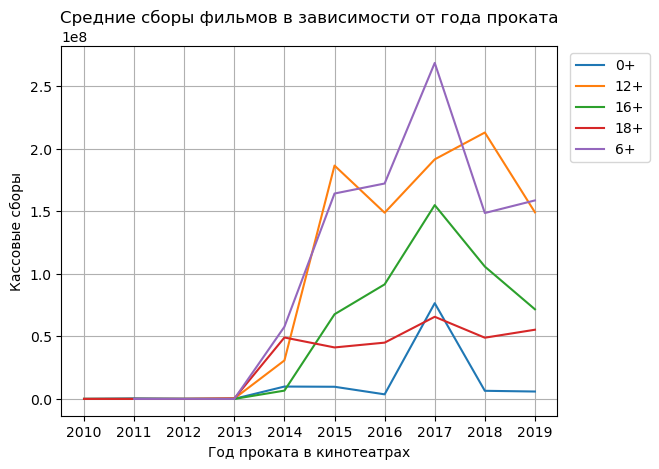

In [85]:
table['mean'].plot();
plt.title('Средние сборы фильмов в зависимости от года проката')
plt.xticks(table.index)
plt.xlabel('Год проката в кинотеатрах')
plt.ylabel('Кассовые сборы')
plt.grid()
plt.legend(bbox_to_anchor=(1.2, 1));

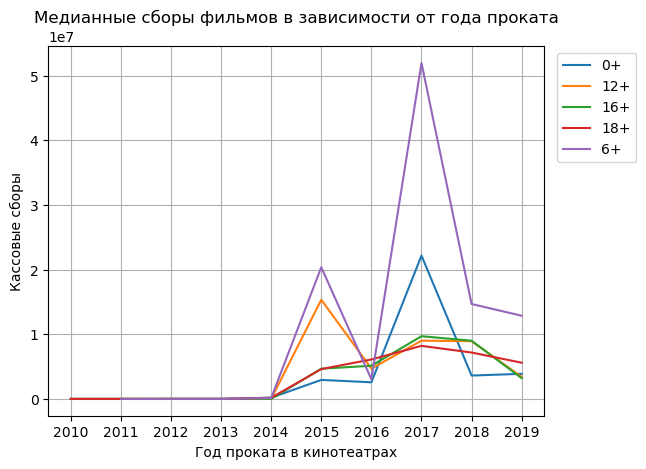

In [86]:
table['median'].plot();
plt.title('Медианные сборы фильмов в зависимости от года проката')
plt.xticks(table.index)
plt.xlabel('Год проката в кинотеатрах')
plt.ylabel('Кассовые сборы')
plt.grid()
plt.legend(bbox_to_anchor=(1.2, 1));

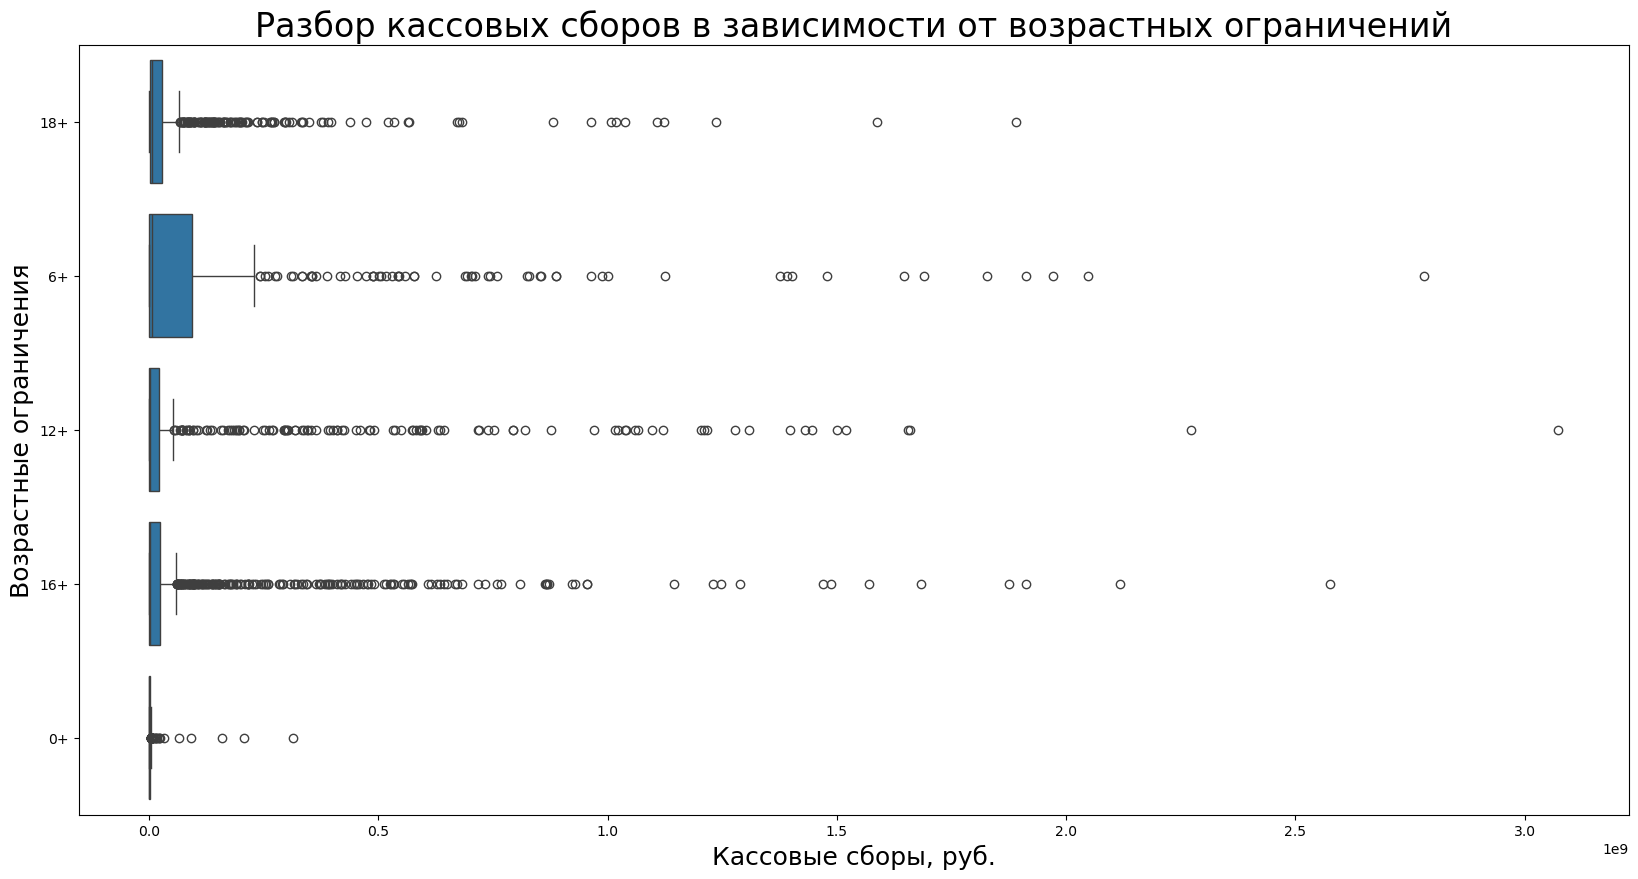

In [87]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, x='box_office', y='age_restriction')
plt.title('Разбор кассовых сборов в зависимости от возрастных ограничений', fontsize=24)
plt.xlabel('Кассовые сборы, руб.', fontsize=18)
plt.ylabel('Возрастные ограничения', fontsize=18)
plt.show()

Каких-то явных тенденций в зависимостях не наблюдается. По средним значениям сборов лидируют, как и было указано выше, категории `6+` и `12+`.

Интересным являются резкий рост сборов фильмов категории  `6+` в 2017 году.

При этом фильмы категории `0+` имеют самые низкие кассовые сборы.

### 5.4. <a id='toc5_4_'></a>Общий вывод по гипотезам  [&#8593;](#toc0_)

В данном разделе были проанализированы несколько гипотез:

**1) Прокат фильмов по годам**  
Период `2010` - `2014`  представлен небольшим количеством информации. Процент фильмов, о которых есть информация о прокате, совсем небольшой. В 2010 это всего `11%`. К `2014` он подрос до `35%`. Но это всего лишь около трети.

Далее (`2015` - `2019`) информации уже больше. В среднем она составляет около `62%`.

Можно выделить следующие факты:
- С `2010` по `2016` информация о прокате росла. Особенно резкий рост был с `2014` по `2015` год (почти `35%`)
- С `2016` по `2018` наблюдается снижение.
- С `2018` по `2019` вновь наблюдается рост.

Менее всего данных представлен `2010` год. Информация есть всего лишь о `11%`.  
А вот полн ее всего представлен `2017` год. Для этого года информация о прокате есть более чем для `70%` фильмов.

---

**2) Сборы фильмов по годам**  
Суммы сборов в период `2010` - `2014` крайне маленькие. И информация явно ошибочная. Например, мультфильм "Белка и Стрелка: Звездные собаки". В данном датасете сборы составляют около `22` тысяч рублей. Однако на КиноПоиске указана информация, что сборы в РФ составили `$6 293 840` и `$7 380 724` по миру.

Подобные строки требуют дальнейшего анализа.

Также мы видим, что среднее и медианное значения очень сильно отличаются. Это говорит о том, что
1) Есть небольшая часть фильмов с огромными сборами.

и\или

2) Для части фильмов сборы указаны некорректно. И мы выяснили, что такие строки действительно есть, особенно в период `2010` - `2014`.


**Динамика:**
- Период с `2010` по `2014` слишком мало представлен, чтобы делать выводы.
- Период с `2014` по `2017` представлен стремительным ростом.
- В период с `2017` по `2019` наблюдается падение сборов.

При этом самые маленькие медианные сборы в `2010` года, а самые большие - в `2017`.

---

**3) Влияние возрастных ограничений на сборы**  
Каких-то явных тенденций в зависимостях не наблюдается. По средним значениям сборов лидируют категории `6+` и `12+`.

Интересным являются резкий рост сборов фильмов категории  `6+` в 2017 году.

При этом фильмы категории `0+` имеют самые низкие кассовые сборы.

In [88]:
_mask = df['production_country'].str.lower().isin(['россия', 'ссср'])
russian_films = df[_mask].copy()

## 6. <a id='toc6_'></a>Анализ фильмов с ГосПоддержкой      [&#8593;](#toc0_)

In [89]:
mask = russian_films['financing_source'].notna()
df_s = russian_films[mask].copy()

In [90]:
df_s['gov_support'] = df_s['refundable_support'] + df_s['nonrefundable_support']

In [91]:
df_s.sample(5)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,show_start_year,main_director,main_genre,support_part,gov_support
2166,Находка.,111_003_615.00,2015-04-02 12:00:00,Художественный,"ООО ""Кинокомпания ""Фигаро""",Россия,В.Демент,Н.Будкина,16+,0.00,24_000_000.00,35_296_950.00,Министерство культуры,6.70,драма,854_334.50,2015,В.Демент,драма,0.68,24_000_000.00
6751,Пиковая дама. Зазеркалье,111_003_619.00,2019-03-14 12:00:00,Художественный,"ООО ""РБ Продакшн""",Россия,А.Домогаров,К.Буслов,16+,15_000_000.00,35_000_000.00,78_355_154.00,Фонд кино,5.10,ужасы,86_371_124.57,2019,А.Домогаров,ужасы,0.64,50_000_000.00
5800,Танки,111_002_618.00,2018-04-26 12:00:00,Художественный,"ЗАО ""МЕДИА-ТРЕСТ""",Россия,К.Дружинин,"Д.Щербанов, О.Антипов",12+,0.00,60_000_000.00,140_005_238.00,Министерство культуры,5.70,"приключения,история,военный",95_755_094.88,2018,К.Дружинин,приключения,0.43,60_000_000.00
3453,Ледокол,111_016_316.00,2016-10-11 12:00:00,Художественный,"ООО ""Продюсерская фирма Игоря Толстунова""",Россия,Н.Хомерики,"И.Толстунов, С.Козлов",12+,100_000_000.00,200_000_000.00,430_000_000.00,Фонд кино,6.50,драма,337_069_662.80,2016,Н.Хомерики,драма,0.70,300_000_000.00
3081,Завтрак у папы,111_020_215.00,2015-12-09 12:00:00,Художественный,"ООО ""Ол Медиа Компани""",Россия,М.Кравченко,"Г.Шабанов, Р.Татаринцев, Э.Илоян",12+,10_000_000.00,20_000_000.00,56_909_520.00,Фонд кино,6.20,комедия,70_790_954.10,2015,М.Кравченко,комедия,0.53,30_000_000.00


Посмотрим статистику по русским фильмам.

In [92]:
table = PrettyTable()
table.field_names = ['', 'Mean', 'Median']
table.add_row([
    'With support',
    round(russian_films.loc[mask, 'ratings'].mean(), 1),
    round(russian_films.loc[mask, 'ratings'].median(), 1)
])
table.add_row([
    'Without support',
    round(russian_films.loc[~mask, 'ratings'].mean(), 1),
    round(russian_films.loc[~mask, 'ratings'].median(), 1)
])
table.add_row([
    'All films',
    round(russian_films['ratings'].mean(), 1),
    round(russian_films['ratings'].median(), 1)
])
print(table)

+-----------------+------+--------+
|                 | Mean | Median |
+-----------------+------+--------+
|   With support  | 6.0  |  6.2   |
| Without support | 6.4  |  6.7   |
|    All films    | 6.3  |  6.6   |
+-----------------+------+--------+


Наблюдается тенденция, что в среднем (и в плане среднего и в плане медианы) фильмы без гос. поддержки имеют более высокий рейтинг, чем фильмы с гос. поддержкой.

---

### 6.1. <a id='toc6_1_'></a>Изменение объема гос. поддержки по годам  [&#8593;](#toc0_)

In [93]:
table = df_s.groupby('show_start_year')['gov_support'].agg(['mean', 'median', 'count'])
table

,mean,median,count
show_start_year,,,
2013,67_173_972.50,67_173_972.50,2
2014,35_033_333.33,27_000_000.00,15
2015,42_725_079.74,30_000_000.00,81
2016,71_135_924.70,35_000_000.00,60
2017,77_657_845.41,40_000_000.00,41
2018,63_150_367.26,50_000_000.00,53
2019,69_625_000.00,40_000_000.00,64


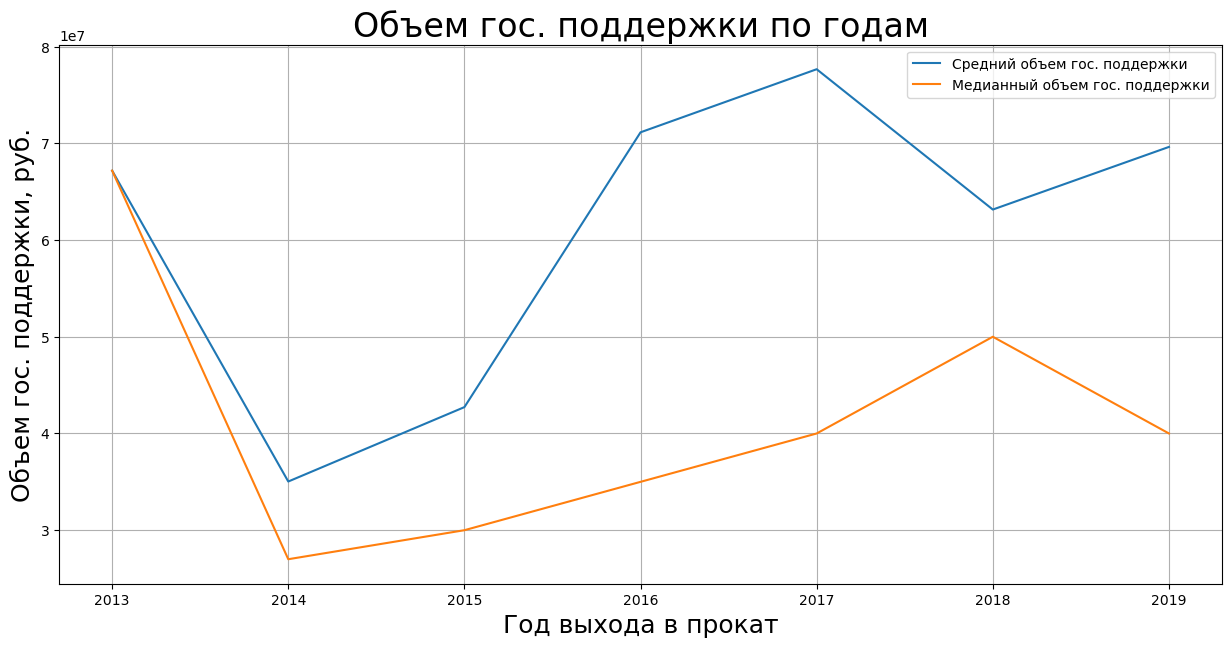

In [94]:
table[['mean', 'median']].plot(figsize=(15, 7))
plt.title('Объем гос. поддержки по годам', fontsize=24)
plt.xlabel('Год выхода в прокат', fontsize=18)
plt.ylabel('Объем гос. поддержки, руб.', fontsize=18)
plt.grid()
plt.legend(['Средний объем гос. поддержки', 'Медианный объем гос. поддержки'])
plt.show()

В период `2010` - `2012` гос. поддержка полностью отсутствовала. В `2013` гос. поддержку получили всего `2` фильма с объемом `67` миллионов. Далее тенденция меняется. Количество фильмов с гос. поддержкой больше, при этом суммы гос. поддержки куда скромнее. В `2017` году было больше фильмов с большими суммами гос. поддержки. В `2018` начали выделять бОльшему количеству фильмов финансы выше среднего.

In [95]:
mean = df_s['support_part'].mean()
median = df_s['support_part'].median()
print(f'  Mean support part for russian films: {mean:.2%}')
print(f'Median support part for russian films: {median:.2%}')

  Mean support part for russian films: 52.89%
Median support part for russian films: 60.98%


---

In [96]:
pivot = df_s.pivot_table(values='gov_support', index='type', aggfunc=['mean', 'median'])
pivot.columns = ['mean_box_office', 'median_box_office']
pivot

,mean_box_office,median_box_office
type,,
Анимационный,82_919_015.00,70_000_000.00
Документальный,3_000_000.00,3_000_000.00
Художественный,59_162_628.69,34_225_000.00


In [97]:
pivot = df_s.pivot_table(values='support_part', index='type', aggfunc=['mean', 'median'])
pivot.columns = ['mean_support_part', 'median_support_part']
pivot

,mean_support_part,median_support_part
type,,
Анимационный,0.39,0.34
Документальный,0.09,0.09
Художественный,0.54,0.62


В данном случае наблюдается интересная тенденция. Б<b>о</b>льшую часть бюджетных денег получили <i>анимационные</i> и <i>художественные</i> фильмы. Небольшая часть досталась <i>документальным</i> фильмам. При этом художественные фильмы спонсируются на `10-15` п.п. больше, нежели анимационные.

А вот фильмы из категорий <i>прочие</i>, <i>научно-популярные</i> и <i>музыкально-развлекательные</i> вообще не получили гос. поддержки.

### 6.2. <a id='toc6_2_'></a>Анализ окупаемости  [&#8593;](#toc0_)

In [98]:
df_s['payback'] = df_s['box_office'] / df_s['budget']
print(f'  Mean payback of films with gov. support: {df_s["payback"].mean():.2%}')
print(f'Median payback of films with gov. support: {df_s["payback"].median():.2%}')

  Mean payback of films with gov. support: 77.98%
Median payback of films with gov. support: 16.17%


Столь огромная разница в средних и медианных значениях говорит о том, что бОльшая часть фильмов не окупается. Медианный процент окупаемости всего около `16%`. Однако средний процент окупаемости выше почти в 5 раз - `78%`. Это говорит о том, что есть несколько фильмов у которых, сборы превышают гос. поддержку в разы.

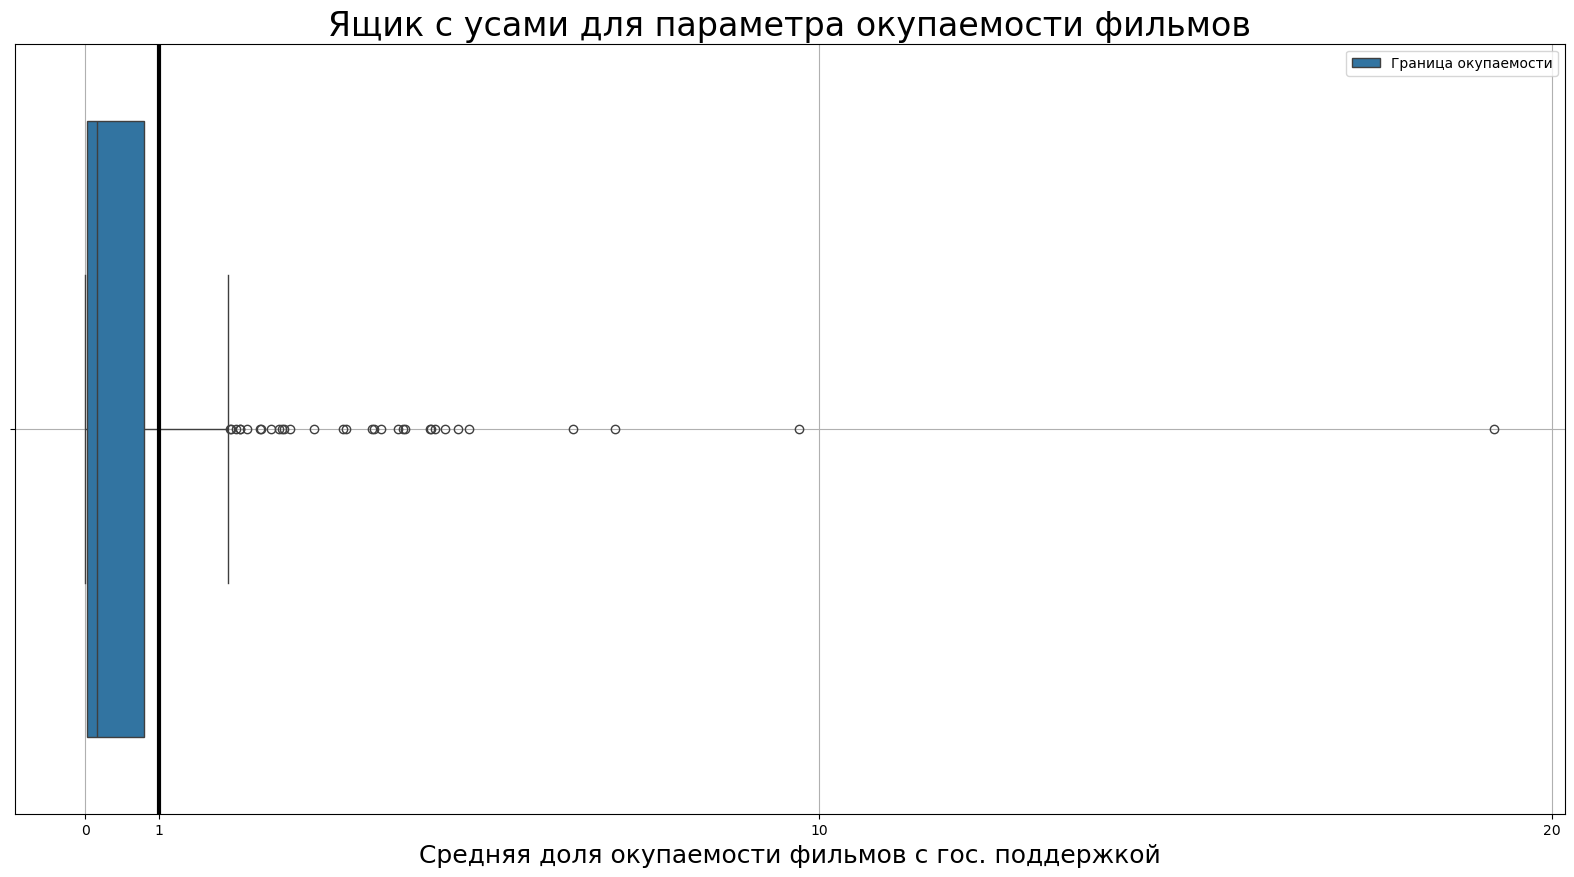

In [99]:
plt.figure(figsize=(20, 10))
sns.boxplot(df_s, x='payback');
plt.grid()
plt.title('Ящик с усами для параметра окупаемости фильмов', fontsize=24)
plt.xlabel('Средняя доля окупаемости фильмов с гос. поддержкой', fontsize=18)
plt.xticks([0, 1, 10, 20])
plt.axvline(x=1, color='black', lw=3)
plt.legend(['Граница окупаемости'])
plt.show()

Данный график подтверждает это.

---

In [100]:
table = df_s.groupby('show_start_year')['payback']

In [101]:
table.agg(['mean', 'median'])

,mean,median
show_start_year,,
2013,0.06,0.06
2014,0.67,0.06
2015,0.47,0.09
2016,0.61,0.13
2017,1.02,0.38
2018,1.19,0.37
2019,0.90,0.24


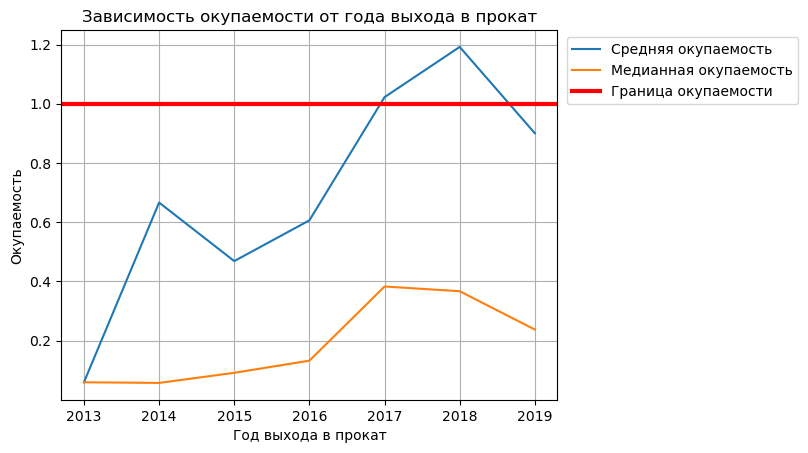

In [102]:
plt.plot(table.mean(), label='Средняя окупаемость')
plt.plot(table.median(), label='Медианная окупаемость')
plt.axhline(y=1, lw=3, color='red', label='Граница окупаемости')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.grid()
plt.title('Зависимость окупаемости от года выхода в прокат')
plt.xlabel('Год выхода в прокат')
plt.ylabel('Окупаемость')
plt.show()

Распределение по годам подтверждает предыдущие идеи. С `2013` по `2017` наблюдался рост окупаемости. А в `2017` - `2019` окупаемость падала. При этом в среднем фильмы с гос. поддержкой никогда не окупаются даже на половину.

### 6.3. <a id='toc6_3_'></a>Вывод по фильмам с гос. поддержкой [&#8593;](#toc0_)

Тут можно выделить несколько фактов:  
- Б<b>о</b>льшую часть бюджетных денег получили <i>анимационные</i> и <i>художественные</i> фильмы. Небольшая часть досталась <i>документальным</i> фильмам. А вот фильмы из категорий <i>прочие</i>, <i>научно-популярные</i> и <i>музыкально-развлекательные</i> вообще не получили гос. поддержки.
- При этом художественные фильмы спонсируются на `10-15` п.п. больше, нежели анимационные.
- В период `2010` - `2012` гос. поддержка полностью отсутствовала. В `2013` гос. поддержку получили всего `2` фильма с объемом `67` миллионов. Далее тенденция меняется. Количество фильмов с гос. поддержкой больше, при этом суммы гос. поддержки куда скромнее. В `2017` году было больше фильмов с большими суммами гос. поддержки. В `2018` начали выделять бОльшему количеству фильмов финансы выше среднего.В период `2010` - `2012` гос. поддержка полностью отсутствовала. В `2013` гос. поддержку получили всего `2` фильма с объемом `67` миллионов. Далее тенденция меняется. Количество фильмов с гос. поддержкой больше, при этом суммы гос. поддержки куда скромнее. В `2017` году было больше фильмов с большими суммами гос. поддержки. В `2018` начали выделять бОльшему количеству фильмов финансы выше среднего.
- Б<b>о</b>льшая часть фильмов с гос. поддержкой не окупается. Медианный процент окупаемости всего около `16%`. Однако средний процент окупаемости выше почти в `5` раз - `78%`. Это говорит о том, что есть несколько фильмов у которых, сборы превышают гос. поддержку в разы.
- С `2013` по `2017` наблюдался рост окупаемости. А в `2017` - `2019` окупаемость падала. При этом в среднем фильмы с гос. поддержкой никогда не окупаются даже на половину.

---

## 7. <a id='toc7_'></a>Общий вывод   [&#8593;](#toc0_)

В рамках данного проекта мы работали с данными о фильмах, выходившими в российском прокате.

Изначально было дано 2 набора данных: общая информация о фильмах (режиссер, жанры, сборы, объем гос. поддержки и т. д.) и информация о сборах. После небольшой очистки они были объединены в один набор данных.

Далее был проведен анализ пропущенных значений, выбросов и аномальных значений. Выбросы и аномальные значения были устранены, если это было целесообразным.

После этого были сгенерированы новые столбцы, а именно: год выхода в прокат, основной жанр, основной режиссер и доля гос. поддержки.

В конце были проверены несколько гипотез и проанализированы фильмы с гос. поддержкой.

---

В данном разделе были проанализированы несколько гипотез:

**1) Прокат фильмов по годам**  
Период `2010` - `2014`  представлен небольшим количеством информации. Процент фильмов, о которых есть информация о прокате, совсем небольшой. В 2010 это всего `11%`. К `2014` он подрос до `35%`. Но это всего лишь около трети.

Далее (`2015` - `2019`) информации уже больше. В среднем она составляет около `62%`.

Можно выделить следующие факты:
- С `2010` по `2016` информация о прокате росла. Особенно резкий рост был с `2014` по `2015` год (почти `35%`)
- С `2016` по `2018` наблюдается снижение.
- С `2018` по `2019` вновь наблюдается рост.

Менее всего данных представлен `2010` год. Информация есть всего лишь о `11%`.  
А вот полн ее всего представлен `2017` год. Для этого года информация о прокате есть более чем для `70%` фильмов.

---

**2) Сборы фильмов по годам**  
Суммы сборов в период `2010` - `2014` крайне маленькие. И информация явно ошибочная. Например, мультфильм "Белка и Стрелка: Звездные собаки". В данном датасете сборы составляют около `22` тысяч рублей. Однако на КиноПоиске указана информация, что сборы в РФ составили `$6 293 840` и `$7 380 724` по миру.

Подобные строки требуют дальнейшего анализа.

Также мы видим, что среднее и медианное значения очень сильно отличаются. Это говорит о том, что
1) Есть небольшая часть фильмов с огромными сборами.

и\или

2) Для части фильмов сборы указаны некорректно. И мы выяснили, что такие строки действительно есть, особенно в период `2010` - `2014`.


**Динамика:**
- Период с `2010` по `2014` слишком мало представлен, чтобы делать выводы.
- Период с `2014` по `2017` представлен стремительным ростом.
- В период с `2017` по `2019` наблюдается падение сборов.

При этом самые маленькие медианные сборы в `2010` года, а самые большие - в `2017`.

---

**3) Влияние возрастных ограничений на сборы**  
Каких-то явных тенденций в зависимостях не наблюдается. По средним значениям сборов лидируют категории `6+` и `12+`.

Интересным являются резкий рост сборов фильмов категории  `6+` в 2017 году.

При этом фильмы категории `0+` имеют самые низкие кассовые сборы.

---

**4)Анализ фильмов с гос. поддержкой.**  
Тут можно выделить несколько фактов:
- Б<b>о</b>льшую часть бюджетных денег получили <i>анимационные</i> и <i>художественные</i> фильмы. Небольшая часть досталась <i>документальным</i> фильмам. А вот фильмы из категорий <i>прочие</i>, <i>научно-популярные</i> и <i>музыкально-развлекательные</i> вообще не получили гос. поддержки.
- При этом художественные фильмы спонсируются на `10-15` п.п. больше, нежели анимационные.
- В период `2010` - `2012` гос. поддержка полностью отсутствовала. В `2013` гос. поддержку получили всего `2` фильма с объемом `67` миллионов. Далее тенденция меняется. Количество фильмов с гос. поддержкой больше, при этом суммы гос. поддержки куда скромнее. В `2017` году было больше фильмов с большими суммами гос. поддержки. В `2018` начали выделять бОльшему количеству фильмов финансы выше среднего.В период `2010` - `2012` гос. поддержка полностью отсутствовала. В `2013` гос. поддержку получили всего `2` фильма с объемом `67` миллионов. Далее тенденция меняется. Количество фильмов с гос. поддержкой больше, при этом суммы гос. поддержки куда скромнее. В `2017` году было больше фильмов с большими суммами гос. поддержки. В `2018` начали выделять бОльшему количеству фильмов финансы выше среднего.
- Б<b>о</b>льшая часть фильмов с гос. поддержкой не окупается. Медианный процент окупаемости всего около `16%`. Однако средний процент окупаемости выше почти в `5` раз - `78%`. Это говорит о том, что есть несколько фильмов у которых, сборы превышают гос. поддержку в разы.
- С `2013` по `2017` наблюдался рост окупаемости. А в `2017` - `2019` окупаемость падала. При этом в среднем фильмы с гос. поддержкой никогда не окупаются даже на половину.